In [1]:
import jax.numpy as jnp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
from astropy.io import fits
import tqdm

from matplotlib import rc
import matplotlib.pyplot as plt
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import cmasher as cm

import load_data as ld
import optimise as opt
import scatters as opt_sc
import init_latents as il
import kfold_cv as kf


In [2]:
file_name = '-giants-and-dwarfs'
spectra_dir_path = '../spec/spectra-reference-stars-APOGEE-giants-and-dwarfs-/'
file_path = '../data/master-APOGEE-giants-and-dwarfs-.fits'
spectra_data, label_data = ld.load_data(spectra_dir_path, file_path, file_name)

../spec/spectra-reference-stars-APOGEE-giants-and-dwarfs-/spectra_data-giants-and-dwarfs.dat
File already exists. Loading spectra data


28it [00:00, 92.93it/s]

Loaded data successfully


In [3]:
labels_teff = label_data['labels'][:,0]
labels_logg = label_data['labels'][:,1]
labels_feh = label_data['labels'][:,2]
labels_mgfe = label_data['labels'][:,6]
labels_vmicro = label_data['labels'][:,12]
labels_vsini = label_data['labels'][:,13]
label_data_small = jnp.vstack((labels_teff, labels_logg, labels_feh, labels_mgfe, labels_vmicro, labels_vsini)).T

In [4]:
labels_teff_err = label_data['labels_err'][:,0]
labels_logg_err = label_data['labels_err'][:,1]
labels_feh_err = label_data['labels_err'][:,2]
labels_mgfe_err = label_data['labels_err'][:,6]
labels_vmicro_err = label_data['labels_err'][:,12]
labels_vsini_err = label_data['labels_err'][:,13]
label_data_small_err = jnp.vstack((labels_teff_err, labels_logg_err, labels_feh_err, labels_mgfe_err, labels_vmicro_err, labels_vsini_err)).T

In [5]:
labels_teff_ivars = label_data['labels_err'][:,0]
labels_logg_ivars = label_data['labels_err'][:,1]
labels_feh_ivars = label_data['labels_err'][:,2]
labels_mgfe_ivars = label_data['labels_err'][:,6]
labels_vmicro_ivars = label_data['labels_err'][:,12]
labels_vsini_ivars = label_data['labels_err'][:,13]
label_data_small_ivars = jnp.vstack((labels_teff_ivars, labels_logg_ivars, labels_feh_ivars, labels_mgfe_ivars, labels_vmicro_ivars, labels_vsini_ivars)).T

In [6]:
n = 4000

test_ID = label_data['ids'][n:]
test_flux = spectra_data['fluxes'][n:]
test_flux_err = spectra_data['fluxes_err'][n:]
test_flux_ivar = spectra_data['fluxes_ivars'][n:]
test_label = label_data_small[n:]
test_label_err = label_data_small_err[n:]
test_label_ivars = label_data_small_ivars[n:]

In [7]:
l2reg = 1000
latent_dim = 'P49'
savepath = '../sav/paper/'
name = '_'+str(latent_dim)+'_L2regstrength'+str(l2reg)+'_omega1-train-highsnrallstars'
alphas = np.load(savepath+'alphas_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
betas = np.load(savepath+'betas_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
zetas = np.load(savepath+'zetas_train_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
ln_noise_fluxes_updated = jnp.log(np.load(savepath+'noise_fluxes_train_giants-withscatters'+str(name)+'.npy', allow_pickle=True))


In [8]:
P = 49
alphas_init, betas_init, zetas_init_test = il.initialise_alphas_betas_zetas(test_label, test_flux, P)
alphas_init.shape, betas_init.shape, zetas_init_test.shape

((6, 49), (8575, 49), (1000, 49))

In [9]:
res_zetas_fromfluxes = opt_sc.get_zetas_test_using_fluxes(test_flux, test_flux_ivar, betas, zetas_init_test, ln_noise_fluxes_updated)
zetas_test_fromfluxes = res_zetas_fromfluxes.params['zetas']

INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-06, Decrease error: 1131400192247.4788, Curvature error: 1.2149279748416256e+18


In [10]:
labels_test_fromflux = zetas_test_fromfluxes @ alphas.T
spectra_test_fromflux = zetas_test_fromfluxes @ betas.T

In [11]:
savepath = '../sav/paper/'
name = '_49_L2regstrength1000_omega1-test-highsnrallstars'
np.save(savepath+'zetas_test_fromflux_giants-withscatters'+str(name), zetas_test_fromfluxes)
np.save(savepath+'labels_test_fromflux_giants-withscatters'+str(name), labels_test_fromflux)
np.save(savepath+'spectra_test_fromflux_giants-withscatters'+str(name), spectra_test_fromflux)


In [8]:
savepath = '../sav/paper/'
name = '_49_L2regstrength1000_omega1-test-highsnrallstars'
zetas_test_fromfluxes = np.load(savepath+'zetas_test_fromflux_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
labels_test_fromflux = np.load(savepath+'labels_test_fromflux_giants-withscatters'+str(name)+'.npy', allow_pickle=True)
spectra_test_fromflux = np.load(savepath+'spectra_test_fromflux_giants-withscatters'+str(name)+'.npy', allow_pickle=True)


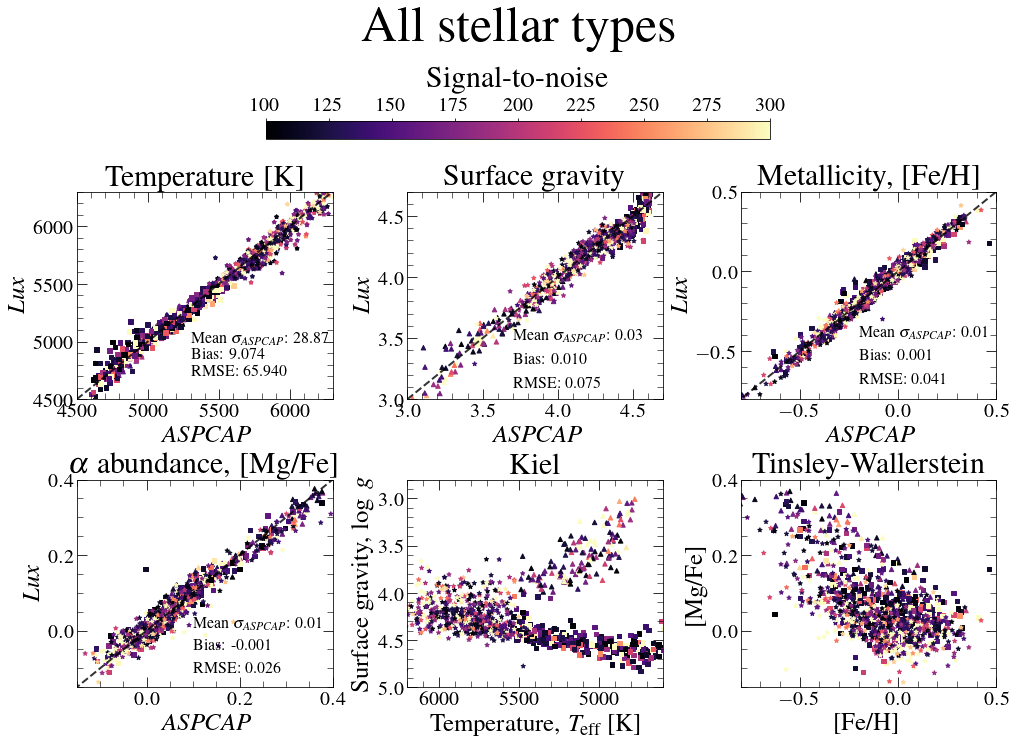

In [9]:
fig = plt.figure(figsize=(14,8), constrained_layout=True)
fig.suptitle(r'All stellar types',fontsize=50,x=0.51,y=1.27)

mask_giants = (labels_test_fromflux[:,0]<5500) & (labels_test_fromflux[:,1]<4)
mask_dwarfs = (labels_test_fromflux[:,0]<5500) & (labels_test_fromflux[:,1]>4)
mask_other = ~mask_giants & ~mask_dwarfs

plt.subplot(2,3,1)
# plt.title('$T_{\mathrm{eff}}$', fontsize=30)
plt.title('Temperature [K]', fontsize=30)
plt.plot([4500,7000], [4500,7000], color='k',alpha=0.8, lw=2, ls='--')
color = plt.scatter(test_label[:,0], labels_test_fromflux[:,0], s=8, rasterized=True, c=label_data['snr'][n:], vmin=100,vmax=300, cmap='magma')
plt.scatter(test_label[:,0][mask_giants], labels_test_fromflux[:,0][mask_giants], s=20, marker='^', rasterized=True, c=label_data['snr'][n:][mask_giants], vmin=100,vmax=300, cmap='magma')
plt.scatter(test_label[:,0][mask_dwarfs], labels_test_fromflux[:,0][mask_dwarfs], s=20, marker='s', rasterized=True, c=label_data['snr'][n:][mask_dwarfs], vmin=100,vmax=300, cmap='magma')
plt.scatter(test_label[:,0][mask_other], labels_test_fromflux[:,0][mask_other], s=20, marker='*', rasterized=True, c=label_data['snr'][n:][mask_other], vmin=100,vmax=300, cmap='magma')
plt.text(5300,4700, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:,0]-labels_test_fromflux[:,0])**2))))), fontsize=16)
plt.text(5300,4850, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:,0]-labels_test_fromflux[:,0]))), fontsize=16)
plt.text(5300,5000, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,0]))), fontsize=16)
plt.xlim(4500,6300)
plt.ylim(4500,6300)
plt.xlabel(r'$ASPCAP$', fontsize=25)
plt.ylabel(r'$Lux$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,2)
# plt.title('$\log~g$', fontsize=30)
plt.title('Surface gravity', fontsize=30)
plt.plot([3,6],[3,6], color='k',alpha=0.8, lw=2, ls='--')
plt.text(3.7,3.1, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:,1]-labels_test_fromflux[:,1])**2))))), fontsize=16)
plt.text(3.7,3.3, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:,1]-labels_test_fromflux[:,1]))), fontsize=16)
plt.text(3.7,3.5, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,1]))), fontsize=16)
plt.scatter(test_label[:,1][mask_giants], labels_test_fromflux[:,1][mask_giants], s=20, marker='^', rasterized=True, c=label_data['snr'][n:][mask_giants], vmin=100,vmax=300, cmap='magma')
plt.scatter(test_label[:,1][mask_dwarfs], labels_test_fromflux[:,1][mask_dwarfs], s=20, marker='s', rasterized=True, c=label_data['snr'][n:][mask_dwarfs], vmin=100,vmax=300, cmap='magma')
plt.scatter(test_label[:,1][mask_other], labels_test_fromflux[:,1][mask_other], s=20, marker='*', rasterized=True, c=label_data['snr'][n:][mask_other], vmin=100,vmax=300, cmap='magma')
plt.xlim(3,4.7)
plt.ylim(3,4.7)
plt.xlabel(r'$ASPCAP$', fontsize=25)
plt.ylabel(r'$Lux$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,3)
# plt.title('[Fe/H]', fontsize=30)
plt.title('Metallicity, [Fe/H]', fontsize=30)
plt.plot([-2,0.5], [-2,0.5], color='k',alpha=0.8, lw=2, ls='--')
plt.text(-0.2,-0.7, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:,2]-labels_test_fromflux[:,2])**2))))), fontsize=16)
plt.text(-0.2,-0.55, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:,2]-labels_test_fromflux[:,2]))), fontsize=16)
plt.text(-0.2,-0.4, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,2]))), fontsize=16)
plt.scatter(test_label[:,2][mask_giants], labels_test_fromflux[:,2][mask_giants], s=20, marker='^', rasterized=True, c=label_data['snr'][n:][mask_giants], vmin=100,vmax=300, cmap='magma')
plt.scatter(test_label[:,2][mask_dwarfs], labels_test_fromflux[:,2][mask_dwarfs], s=20, marker='s', rasterized=True, c=label_data['snr'][n:][mask_dwarfs], vmin=100,vmax=300, cmap='magma')
plt.scatter(test_label[:,2][mask_other], labels_test_fromflux[:,2][mask_other], s=20, marker='*', rasterized=True, c=label_data['snr'][n:][mask_other], vmin=100,vmax=300, cmap='magma')
plt.xlim(-0.8,0.5)
plt.ylim(-0.8,0.5)
plt.ylabel(r'$Lux$', fontsize=25)
plt.xlabel(r'$ASPCAP$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,4)
# plt.title('[Mg/Fe]', fontsize=30)
plt.title(r'$\alpha$ abundance, [Mg/Fe]', fontsize=30)
plt.plot([-0.6,0.6], [-0.6,0.6], color='k',alpha=0.8, lw=2, ls='--')
plt.text(0.1,-0.11, 'RMSE: '+str("{:.3f}".format(jnp.sqrt(1./len(test_label)*(jnp.nansum((test_label[:,3]-labels_test_fromflux[:,3])**2))))), fontsize=16)
plt.text(0.1,-0.05, 'Bias: '+str("{:.3f}".format(jnp.mean(test_label[:,3]-labels_test_fromflux[:,3]))), fontsize=16)
plt.text(0.1,0.01, 'Mean $\sigma_{ASPCAP}$: '+str("{:.2f}".format(jnp.mean(test_label_err[:n,3]))), fontsize=16)
plt.scatter(test_label[:,3][mask_giants], labels_test_fromflux[:,3][mask_giants], s=20, marker='^', rasterized=True, c=label_data['snr'][n:][mask_giants], vmin=100,vmax=300, cmap='magma')
plt.scatter(test_label[:,3][mask_dwarfs], labels_test_fromflux[:,3][mask_dwarfs], s=20, marker='s', rasterized=True, c=label_data['snr'][n:][mask_dwarfs], vmin=100,vmax=300, cmap='magma')
plt.scatter(test_label[:,3][mask_other], labels_test_fromflux[:,3][mask_other], s=20, marker='*', rasterized=True, c=label_data['snr'][n:][mask_other], vmin=100,vmax=300, cmap='magma')
plt.xlim(-0.15,0.4)
plt.ylim(-0.15,0.4)
plt.xlabel(r'$ASPCAP$', fontsize=25)
plt.ylabel(r'$Lux$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,5)
plt.title('Kiel', fontsize=30)
# plt.scatter(test_label[:,0], labels_test_fromflux[:,1], s=8, rasterized=True, c=label_data['snr'][n:], vmin=100,vmax=300, cmap='magma')
plt.scatter(test_label[:,0][mask_giants], labels_test_fromflux[:,1][mask_giants], s=20, marker='^', rasterized=True, c=label_data['snr'][n:][mask_giants], vmin=100,vmax=300, cmap='magma')
plt.scatter(test_label[:,0][mask_dwarfs], labels_test_fromflux[:,1][mask_dwarfs], s=20, marker='s', rasterized=True, c=label_data['snr'][n:][mask_dwarfs], vmin=100,vmax=300, cmap='magma')
plt.scatter(test_label[:,0][mask_other], labels_test_fromflux[:,1][mask_other], s=20, marker='*', rasterized=True, c=label_data['snr'][n:][mask_other], vmin=100,vmax=300, cmap='magma')
plt.xlim(6200,4600)
plt.ylim(5, 2.8)
# plt.xlabel(r'$T_{\mathrm{eff}}$ [K]', fontsize=25)
# plt.ylabel(r'$\log~g$', fontsize=25)
plt.xlabel(r'Temperature, $T_{\mathrm{eff}}$ [K]', fontsize=25)
plt.ylabel(r'Surface gravity, $\log~g$', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()

plt.subplot(2,3,6)
plt.title('Tinsley-Wallerstein', fontsize=30)
plt.scatter(test_label[:,2][mask_giants], labels_test_fromflux[:,3][mask_giants], s=20, marker='^', rasterized=True, c=label_data['snr'][n:][mask_giants], vmin=100,vmax=300, cmap='magma')
plt.scatter(test_label[:,2][mask_dwarfs], labels_test_fromflux[:,3][mask_dwarfs], s=20, marker='s', rasterized=True, c=label_data['snr'][n:][mask_dwarfs], vmin=100,vmax=300, cmap='magma')
plt.scatter(test_label[:,2][mask_other], labels_test_fromflux[:,3][mask_other], s=20, marker='*', rasterized=True, c=label_data['snr'][n:][mask_other], vmin=100,vmax=300, cmap='magma')
# plt.scatter(test_label[:,2], labels_test_fromflux[:,3], s=8, rasterized=True, c=label_data['snr'][n:], vmin=100,vmax=300, cmap='magma')
plt.xlim(-0.8,0.5)
plt.ylim(-0.15,0.4)
plt.xlabel(r'[Fe/H]', fontsize=25)
plt.ylabel(r'[Mg/Fe]', fontsize=25)
plt.tick_params(which='major',labelsize=20,direction='in',top=True,right=True,length=10)
plt.tick_params(which='minor', length=6, direction='in',top=True,right=True)
plt.minorticks_on()



cbar_ax = fig.add_axes([0.26, 1.04, 0.5,0.03])
cbar = fig.colorbar(color, cax = cbar_ax,orientation='horizontal')
cbar.set_label(label=r'Signal-to-noise',fontsize=30, labelpad=10)
cbar.ax.tick_params(labelsize=20)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')

plt.savefig('../plots/paper/allstars-Lux.pdf',dpi=200, bbox_inches = 'tight')